<a href="https://colab.research.google.com/github/Divya7803/hotel-reservation-demo/blob/main/miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/Healthcare-Diabetes.csv')

In [2]:
df.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


In [4]:
df.describe()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000,2768.000000
mean,1384.500000,3.742775,121.102601,69.134393,20.824422,80.127890,32.137392,0.471193,33.132225,0.343931
std,799.197097,3.323801,32.036508,19.231438,16.059596,112.301933,8.076127,0.325669,11.777230,0.475104
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,692.750000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,1384.500000,3.000000,117.000000,72.000000,23.000000,37.000000,32.200000,0.375000,29.000000,0.000000
75%,2076.250000,6.000000,141.000000,80.000000,32.000000,130.000000,36.625000,0.624000,40.000000,1.000000
max,2768.000000,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


In [7]:
# Replace 0s with NaN in critical columns
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Impute missing values with median
df.fillna(df.median(), inplace=True)


<Axes: >

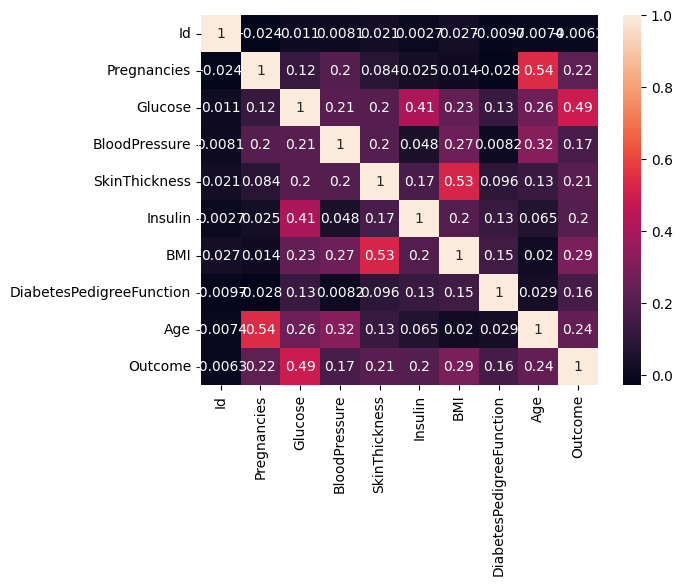

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Outcome', data=df)  # Class distribution
sns.heatmap(df.corr(), annot=True)   # Feature correlation

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Outcome', axis=1))

In [10]:
from sklearn.model_selection import train_test_split

X = X_scaled
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       367
           1       0.98      0.96      0.97       187

    accuracy                           0.98       554
   macro avg       0.98      0.97      0.98       554
weighted avg       0.98      0.98      0.98       554



ROC AUC Score: 0.9731600343877952


<Axes: >

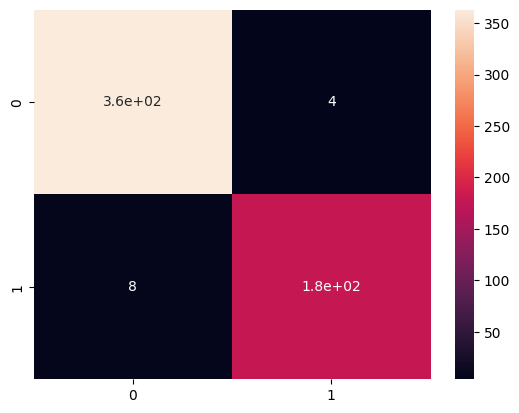

In [12]:
from sklearn.metrics import roc_auc_score, confusion_matrix

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 10]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 10], 'n_estimators': [100, 200]})

In [14]:
import joblib
joblib.dump(model, 'diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [17]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
app = Flask(__name__)
# Load model and scaler
model = joblib.load('diabetes_model.pkl')
scaler = joblib.load('scaler.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()  # Get JSON data from request
    input_data = np.array(data['input']).reshape(1, -1)  # Convert to 2D array
    input_scaled = scaler.transform(input_data)  # Scale input
    prediction = model.predict(input_scaled)  # Make prediction
    return jsonify({'diabetes': int(prediction[0])})  # Return result as JSON

if __name__ == '__main__':
    app.run(debug=True)  # Use debug=True during development


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
